<a href="https://colab.research.google.com/github/sherlock216/20251R0136COSE47101/blob/main/GMM_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Probabilistic Clustering is different from K-Means clustering. It assigns a probability to each data point indicating the likelihood of belonging to each cluster. GMM(Gaussian Mixture Model) is a common probabilistic clustering model.

It assumes a mixture of Gaussian distributions, and it has E-Step and M-Step.
E-Step: Calculate the probability that each data point belongs to each other, based on the current parameters.
M-Step: Update the parameters of each Gaussian distribution to maximize the likelihood of the data given the model.

# 1. Preparing the dataset for clustering

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import glob
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

In [3]:
# 데이터 로드
# 경로에 있는 모든 github_profiles*.csv 파일을 찾음
file_paths = glob.glob('/content/drive/MyDrive/Colab Notebooks/COSE471/test/results/github_profiles*.csv')

# 여러 파일을 읽어서 하나로 합치기
df_list = [pd.read_csv(fp, index_col=False).fillna(0) for fp in file_paths]
df_combined = pd.concat(df_list, ignore_index=True)

print(f"총 {len(df_combined)}개의 사용자 데이터 로드 완료")

총 2446개의 사용자 데이터 로드 완료


In [4]:
print(len(df_list))

14


In [6]:
# 프로그래밍 언어 컬럼만 선택
language_columns = df_combined.columns[1:]  # 첫 번째 컬럼(유저 ID) 제외
X = df_combined[language_columns].values
X

array([[0.  , 0.  , 0.33, ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.06, 0.  , ..., 0.  , 0.06, 0.  ],
       ...,
       [0.  , 0.04, 0.02, ..., 0.  , 0.  , 0.21],
       [0.  , 0.  , 0.67, ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ]])

In [7]:
# 데이터 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. What if we do PCA for displaying with graphs?

In [8]:
# PCA를 사용하여 2차원으로 차원 축소
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

In [9]:
# EM 클러스터링 수행
n_components = 4  # 클러스터 수
gmm = GaussianMixture(n_components=n_components, random_state=42)
labels = gmm.fit_predict(X_pca)

In [10]:
# 5. 2D 공간 그리드 생성
x = np.linspace(X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1, 200)
y = np.linspace(X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1, 200)
X_grid, Y_grid = np.meshgrid(x, y)
XX = np.array([X_grid.ravel(), Y_grid.ravel()]).T

In [11]:
# Predict cluster each data point belongs to
Z = gmm.predict_proba(XX)

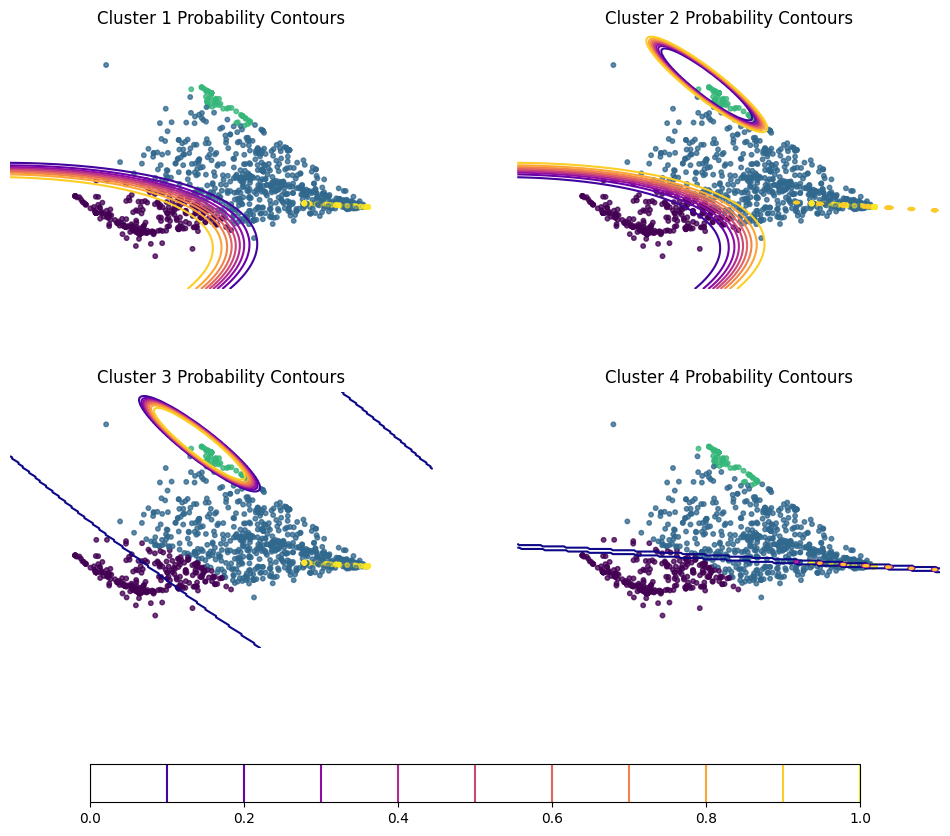

In [12]:
# 7. 시각화 (클러스터별 확률 컨투어)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for i in range(4):
    ax = axes[i // 2, i % 2]
    Z_i = Z[:, i].reshape(X_grid.shape)

    contour = ax.contour(X_grid, Y_grid, Z_i, levels=10, cmap='plasma')
    ax.set_title(f"Cluster {i+1} Probability Contours")
    ax.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, s=10, alpha=0.5)
    ax.set_xlabel("PCA 1")
    ax.set_ylabel("PCA 2")
    ax.set_axis_off()

plt.subplots_adjust(hspace=0.4)
fig.colorbar(contour, ax=axes, orientation='horizontal', fraction=0.05)
plt.show()

In [13]:
# Probability each data point of being part of a certain cluster
probs = gmm.predict_proba(X_pca)
probs[0]

array([8.40073403e-001, 1.59926597e-001, 1.05877125e-218, 0.00000000e+000])

In [14]:
from sklearn.metrics import silhouette_score, pairwise_distances

# Silhouette Score 계산
labels = gmm.predict(X_pca)
sil_score = silhouette_score(X_pca, labels)
print('Silhouette coefficient of GMM:', sil_score)

# Dunn Index 함수 정의
def dunn_index(X, labels):
    n_clusters = len(np.unique(labels))
    distances = pairwise_distances(X)

    inter_cluster_distances = []
    for i in range(n_clusters):
        for j in range(i + 1, n_clusters):
            cluster_i = X[labels == i]
            cluster_j = X[labels == j]
            inter_dist = np.min(pairwise_distances(cluster_i, cluster_j))
            inter_cluster_distances.append(inter_dist)

    intra_cluster_distances = []
    for i in range(n_clusters):
        cluster_i = X[labels == i]
        intra_dist = np.max(pairwise_distances(cluster_i))
        intra_cluster_distances.append(intra_dist)

    min_inter = np.min(inter_cluster_distances)
    max_intra = np.max(intra_cluster_distances)

    return min_inter / max_intra

# Dunn Index 계산
dunn = dunn_index(X_pca, labels)
print('Dunn Index of GMM:', dunn)


Silhouette coefficient of GMM: 0.31486843077973203
Dunn Index of GMM: 0.0008273767027234445


In [15]:
df_combined['cluster'] = labels

# CSV로 저장
df_combined.to_csv('/content/drive/MyDrive/Colab Notebooks/COSE471/test/final_profiles_with_clusters.csv', index=False)

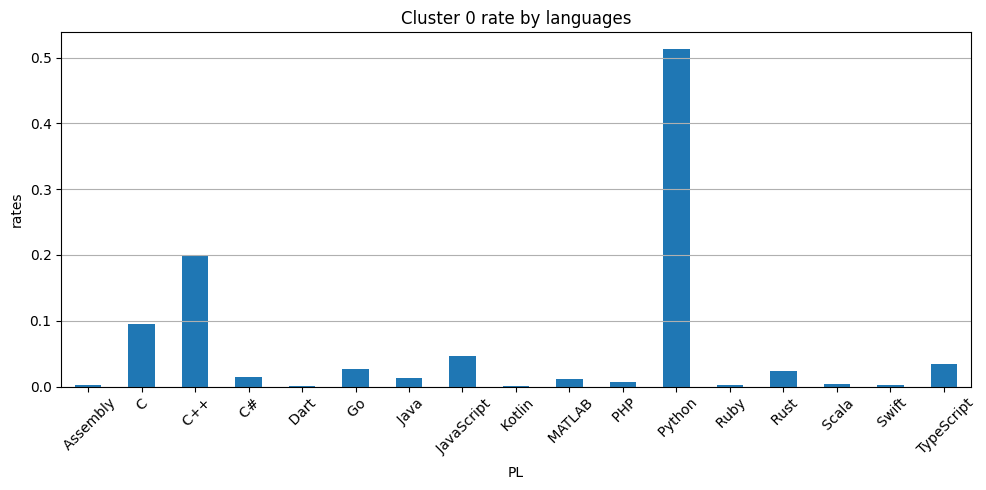

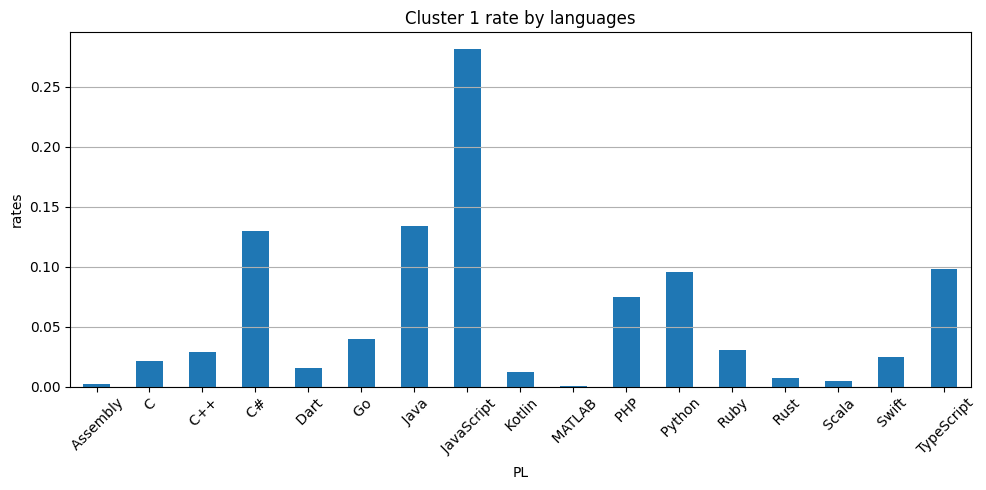

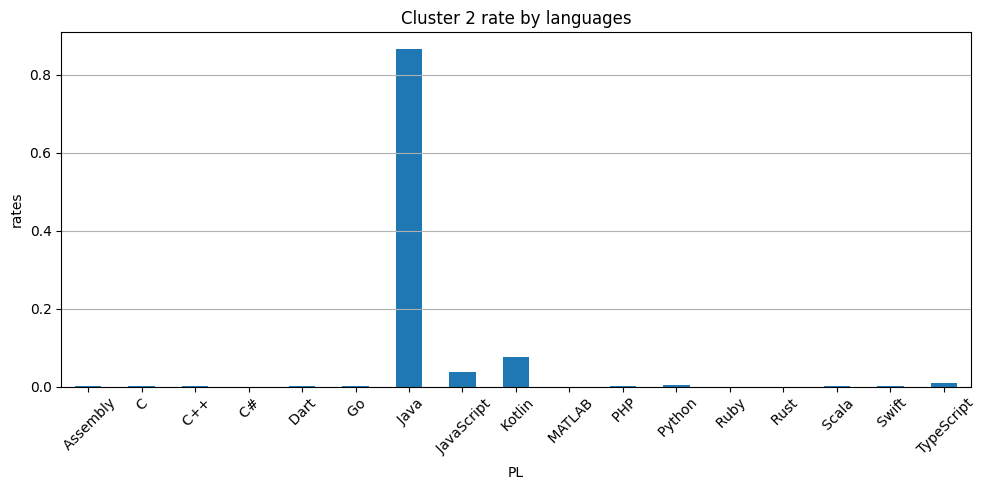

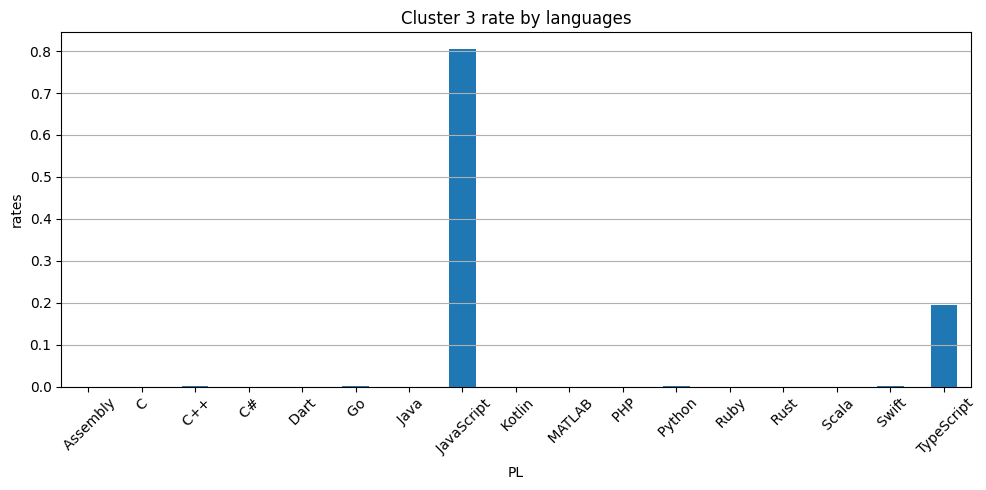

In [17]:
language_columns = df_combined.columns[1:-1]  # '유저', 'ID', ..., 'cluster' 제외

# 클러스터별 평균 언어 비율 계산
cluster_profiles = df_combined.groupby('cluster')[language_columns].mean()

# 시각화: 각 클러스터의 평균 언어 비율
for cluster_id in cluster_profiles.index:
    plt.figure(figsize=(10, 5))
    cluster_profiles.loc[cluster_id].plot(kind='bar')
    plt.title(f"Cluster {cluster_id} rate by languages")
    plt.ylabel("rates")
    plt.xlabel("PL")
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

In [22]:
# 클러스터별로 가장 높은 확률을 가진 인덱스 찾기
probs = gmm.predict_proba(X_pca)  # 또는 GMM에 사용한 입력 (X_scaled 등)
# 몇 명 뽑을지 설정
top_n = 5

# 클러스터별 상위 top_n 사용자 ID 출력
for cluster_id in range(gmm.n_components):
    # 해당 클러스터에 대한 소속 확률 벡터
    cluster_probs = probs[:, cluster_id]

    # 확률 내림차순으로 인덱스 정렬
    top_indices = np.argsort(cluster_probs)[::-1][:top_n]

    print(f"\n🔹 Cluster {cluster_id} 상위 {top_n} 대표자:")
    for rank, idx in enumerate(top_indices, 1):
        user_id = df_combined.iloc[idx]['유저 ID']
        prob = cluster_probs[idx]
        print(f"  {rank}. ID: {user_id} (확률: {prob:.4f})")



🔹 Cluster 0 상위 5 대표자:
  1. ID: mxxo (확률: 0.9998)
  2. ID: mxxo (확률: 0.9998)
  3. ID: kali-muon (확률: 0.9998)
  4. ID: kali-muon (확률: 0.9998)
  5. ID: nidhi-desai (확률: 0.9998)

🔹 Cluster 1 상위 5 대표자:
  1. ID: chrisrochford (확률: 1.0000)
  2. ID: chrisrochford (확률: 1.0000)
  3. ID: Ankhana (확률: 1.0000)
  4. ID: Ankhana (확률: 1.0000)
  5. ID: xiaodekaixin (확률: 1.0000)

🔹 Cluster 2 상위 5 대표자:
  1. ID: shivayogih (확률: 0.9996)
  2. ID: mendeleev23 (확률: 0.9996)
  3. ID: shivayogih (확률: 0.9996)
  4. ID: mendeleev23 (확률: 0.9996)
  5. ID: max-zhilin (확률: 0.9996)

🔹 Cluster 3 상위 5 대표자:
  1. ID: katieburak (확률: 0.9997)
  2. ID: AkshantUjjwal (확률: 0.9997)
  3. ID: KaueFernandes01 (확률: 0.9997)
  4. ID: Refagi (확률: 0.9997)
  5. ID: AbhinavaSanthosh (확률: 0.9997)


# 3. Solution: Do not use PCA

In [28]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

# 1. StandardScaler로 정규화된 원본 데이터 사용
X_input = X_scaled  # PCA 사용 X

# 2. GMM 학습
gmm_pure = GaussianMixture(n_components=4, random_state=42)
gmm_pure.fit(X_input)
labels = gmm_pure.predict(X_input)

# 3. 평가
sil_score_pure = silhouette_score(X_input, labels)
print("Silhouette score without PCA:", sil_score_pure)
# Dunn Index 함수 정의
def dunn_index(X, labels):
    n_clusters = len(np.unique(labels))
    distances = pairwise_distances(X)

    inter_cluster_distances = []
    for i in range(n_clusters):
        for j in range(i + 1, n_clusters):
            cluster_i = X[labels == i]
            cluster_j = X[labels == j]
            inter_dist = np.min(pairwise_distances(cluster_i, cluster_j))
            inter_cluster_distances.append(inter_dist)

    intra_cluster_distances = []
    for i in range(n_clusters):
        cluster_i = X[labels == i]
        intra_dist = np.max(pairwise_distances(cluster_i))
        intra_cluster_distances.append(intra_dist)

    min_inter = np.min(inter_cluster_distances)
    max_intra = np.max(intra_cluster_distances)

    return min_inter / max_intra

# Dunn Index 계산
dunn_pure = dunn_index(X_input, labels)
print('Dunn Index of GMM:', dunn_pure)

Silhouette score without PCA: 0.05215922187121185
Dunn Index of GMM: 0.004271119617973587


In [24]:
probs = gmm_pure.predict_proba(X_input)
probs[0]

array([1.44381070e-14, 3.05072964e-24, 9.99997829e-01, 2.17137145e-06])

In [26]:
# 필요시 사용. pca를 이미 실행해버렸다면 사용할 것. 기존 cluster 컬럼 삭제
df_combined.drop('cluster', axis=1, inplace=True)

In [27]:
df_combined['cluster'] = labels

# CSV로 저장
df_combined.to_csv('/content/drive/MyDrive/Colab Notebooks/COSE471/test/final_profiles_with_clusters.csv', index=False)

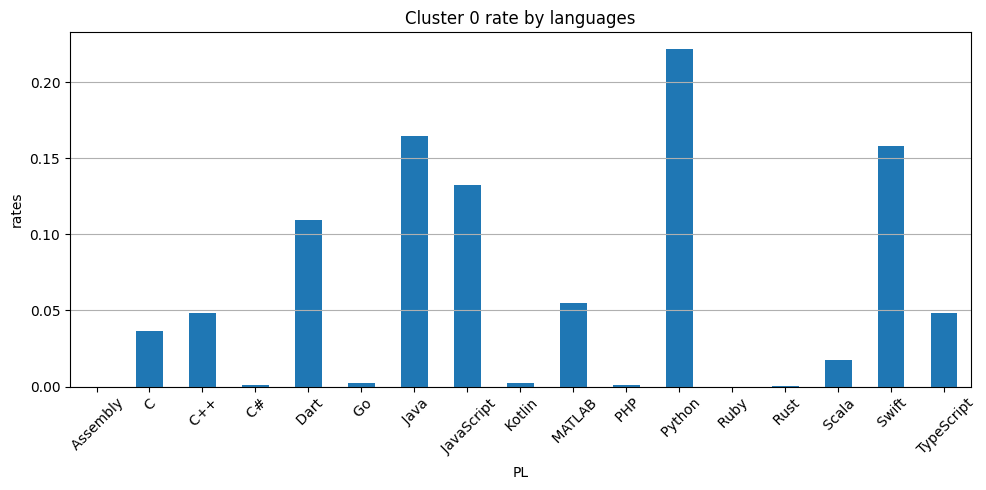

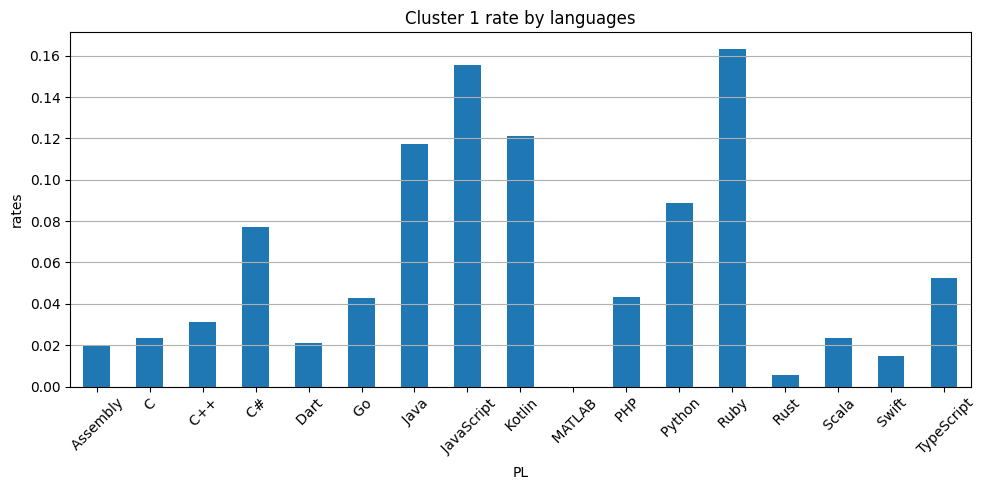

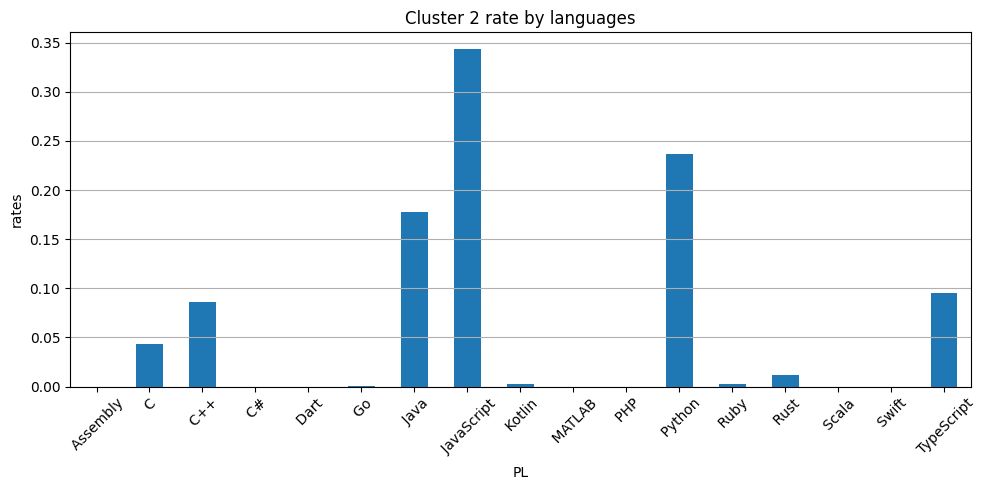

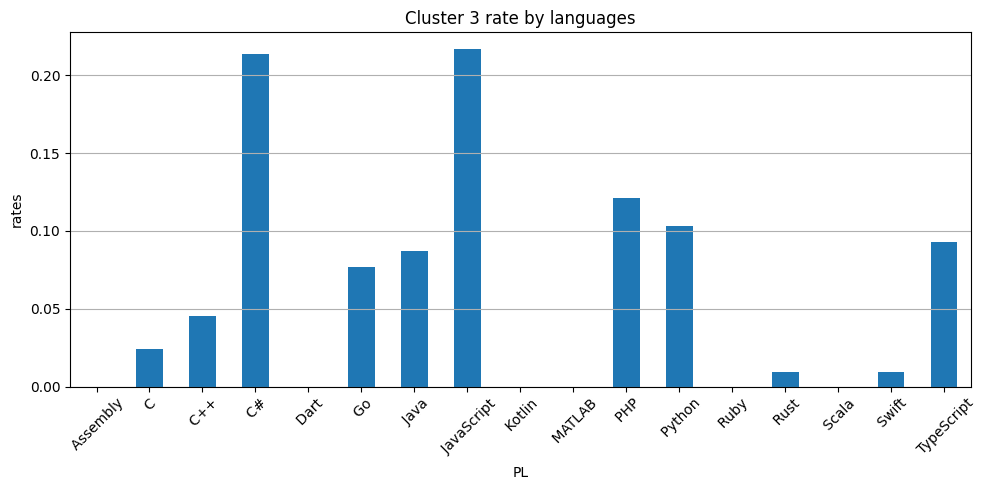

In [29]:
language_columns = df_combined.columns[1:-1]  # '유저', 'ID', ..., 'cluster' 제외

# 클러스터별 평균 언어 비율 계산
cluster_profiles = df_combined.groupby('cluster')[language_columns].mean()

# 시각화: 각 클러스터의 평균 언어 비율
for cluster_id in cluster_profiles.index:
    plt.figure(figsize=(10, 5))
    cluster_profiles.loc[cluster_id].plot(kind='bar')
    plt.title(f"Cluster {cluster_id} rate by languages")
    plt.ylabel("rates")
    plt.xlabel("PL")
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

In [30]:
# 클러스터별로 가장 높은 확률을 가진 인덱스 찾기
probs = gmm_pure.predict_proba(X_input)  # 또는 GMM에 사용한 입력 (X_scaled 등)
# 몇 명 뽑을지 설정
top_n = 5

# 클러스터별 상위 top_n 사용자 ID 출력
for cluster_id in range(gmm_pure.n_components):
    # 해당 클러스터에 대한 소속 확률 벡터
    cluster_probs = probs[:, cluster_id]

    # 확률 내림차순으로 인덱스 정렬
    top_indices = np.argsort(cluster_probs)[::-1][:top_n]

    print(f"\n🔹 Cluster {cluster_id} 상위 {top_n} 대표자:")
    for rank, idx in enumerate(top_indices, 1):
        user_id = df_combined.iloc[idx]['유저 ID']
        prob = cluster_probs[idx]
        print(f"  {rank}. ID: {user_id} (확률: {prob:.4f})")


🔹 Cluster 0 상위 5 대표자:
  1. ID: duyguozc (확률: 1.0000)
  2. ID: SakuniJayasinghe (확률: 1.0000)
  3. ID: Haileleul-K (확률: 1.0000)
  4. ID: minhthuc251 (확률: 1.0000)
  5. ID: andreiYarash (확률: 1.0000)

🔹 Cluster 1 상위 5 대표자:
  1. ID: whale1st (확률: 1.0000)
  2. ID: Ankhana (확률: 1.0000)
  3. ID: nee-vir (확률: 1.0000)
  4. ID: Ankhana (확률: 1.0000)
  5. ID: mendeleev23 (확률: 1.0000)

🔹 Cluster 2 상위 5 대표자:
  1. ID: llarruda (확률: 1.0000)
  2. ID: splainez (확률: 1.0000)
  3. ID: Piootrek (확률: 1.0000)
  4. ID: sefagurel (확률: 1.0000)
  5. ID: slarge (확률: 1.0000)

🔹 Cluster 3 상위 5 대표자:
  1. ID: caikuner (확률: 1.0000)
  2. ID: angelitocax (확률: 1.0000)
  3. ID: sajjad2274 (확률: 1.0000)
  4. ID: Strike2001 (확률: 1.0000)
  5. ID: zachreborn (확률: 1.0000)
